In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

# from matplotlib.patches import Rectangle
# from matplotlib.collections import PatchCollection
# from matplotlib.colors import rgb2hex
# from generativepy.color import Color                        # NOTE: additional package generativepy is required (pip)
# from PIL import ImageColor

from matplotlib.colors import Normalize, LogNorm
import matplotlib.cm as cm

# img_dir = './img/bivariate_maps/'
# if not exists(img_dir):
#     makedirs(img_dir)


# 1. Functions

In [195]:
# def prepare_gdf(year, level):
#     # --- LOAD DATA ---
#     data_dir = '../data/birthPlace_spain_v_outside/'
#     file_extension = '_birthPlace_spain_v_outside.csv'
#     file = str(year) + file_extension

#     # avoid data type errors
#     df = pd.read_csv(data_dir + file)
#     df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
#     df['Birth_Place'] = df['Birth_Place'].astype(str).str.strip()   # convert to str and strip spaces

#     # ignore sex
#     df = df.groupby([level, 'Birth_Place'], as_index=False)['Value'].sum()

#     # --- INITIAL DATA PROCESSING ---
#     # separate spain vs outside spain
#     spain = df[df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby(level, as_index=False)['Value'].sum().rename(columns={'Value':'Population_Spain'})

#     outside_spain = df[~df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby(level, as_index=False)['Value'].sum().rename(columns={'Value':'Population_outside_Spain'})    # also accounts for 'Not available'

#     # merge into single dataframe
#     spain_vs_outside = pd.merge(spain, outside_spain, on=level, how='outer').fillna(0)

#     # compute relevant metrics
#     spain_vs_outside['Total_population'] = spain_vs_outside['Population_Spain'] + spain_vs_outside['Population_outside_Spain']

#     # --- MERGE WITH GEOMETRY AND MORE PROCESSING ---
#     # load geometry
#     if level == 'District':
#         geometry_file = '../data/geometry/districts_geometry.csv'
#     elif level == 'Neighborhood':
#         geometry_file = '../data/geometry/neighborhoods_geometry.csv'

#     geometry_df = gpd.read_file(geometry_file)
#     geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)    # convert WKT strings to shapes

#     # convert to GeoDataFrame
#     gdf = gpd.GeoDataFrame(geometry_df, geometry='Geometry_etrs89', crs="EPSG:25831")

#     # merge df and gdf (data + geometry)
#     df = pd.merge(gdf, spain_vs_outside, left_on=level, right_on=level, how='left')

#     # compute additional metrics
#     df['Area_km2'] = df['Geometry_etrs89'].area / 1e6  # area in square kilometers
#     df['Population_density'] = df['Total_population'] / df['Area_km2']
#     df['Immigrant_density'] = df['Population_outside_Spain'] / df['Area_km2']

#     return df

# def plot_density(year, level, ax):
#     global vmin, vmax

#     gdf = prepare_gdf(year, level)

#     gdf.plot(column='Population_density', ax=ax, cmap='cividis', vmin=vmin, vmax=vmax, legend=False)
#     ax.axis('off')

#     # black lines for boundaries (better visibility)
#     gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

# def plot_immigrant_density(year, level, ax):
#     global vmin, vmax
#     gdf = prepare_gdf(year, level)

#     gdf.plot(column='Immigrant_density', ax=ax, cmap='cividis', vmin=vmin, vmax=vmax, legend=False)
#     ax.axis('off')

#     # black lines for boundaries (better visibility)
#     gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

# def add_legend(fig):
#     global vmin, vmax

#     # new axis for the legend
#     norm = Normalize(vmin=vmin, vmax=vmax)
#     cmap = cm.cividis
#     sm = cm.ScalarMappable(norm=norm, cmap=cmap)
#     sm.set_array([])

#     # make space for the legend
#     fig.subplots_adjust(right=0.85)

#     # colorbar in its own axis
#     cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
#     cbar = fig.colorbar(sm, cax=cbar_ax)

#     cbar.set_label('Population Density per km$^2$', fontsize=14, rotation=270, labelpad=20)

#     cbar.set_label('Population Density per km$^2$', 
#                 fontsize=30,  
#                 rotation=270, 
#                 labelpad=55)  

#     # tick parameters
#     cbar.ax.tick_params(
#         labelsize=18,
#         length=8,                    
#         width=4,                     
#         color='black',               
#         pad=10,                      
#         direction='out'              
#     )
#     cbar.ax.tick_params(axis='y', labelrotation=270)


In [196]:
def prepare_gdf(year, level):
    # --- LOAD DATA ---
    data_dir = '../data/birthPlace_spain_v_outside/'
    file_extension = '_birthPlace_spain_v_outside.csv'
    file = str(year) + file_extension

    # avoid data type errors
    df = pd.read_csv(data_dir + file)
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
    df['Birth_Place'] = df['Birth_Place'].astype(str).str.strip()   # convert to str and strip spaces

    # ignore sex
    df = df.groupby([level, 'Birth_Place'], as_index=False)['Value'].sum()

    # --- INITIAL DATA PROCESSING ---
    # separate spain vs outside spain
    spain = df[df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby(level, as_index=False)['Value'].sum().rename(columns={'Value':'Population_Spain'})

    outside_spain = df[~df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby(level, as_index=False)['Value'].sum().rename(columns={'Value':'Population_outside_Spain'})    # also accounts for 'Not available'

    # merge into single dataframe
    spain_vs_outside = pd.merge(spain, outside_spain, on=level, how='outer').fillna(0)

    # compute relevant metrics
    spain_vs_outside['Total_population'] = spain_vs_outside['Population_Spain'] + spain_vs_outside['Population_outside_Spain']

    # --- MERGE WITH GEOMETRY AND MORE PROCESSING ---
    # load geometry
    if level == 'District':
        geometry_file = '../data/geometry/districts_geometry.csv'
    elif level == 'Neighborhood':
        geometry_file = '../data/geometry/neighborhoods_geometry.csv'

    geometry_df = gpd.read_file(geometry_file)
    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)    # convert WKT strings to shapes

    # convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry_df, geometry='Geometry_etrs89', crs="EPSG:25831")

    # merge df and gdf (data + geometry)
    df = pd.merge(gdf, spain_vs_outside, left_on=level, right_on=level, how='left')

    # compute additional metrics
    df['Area_km2'] = df['Geometry_etrs89'].area / 1e6  # area in square kilometers
    df['Population_density'] = df['Total_population'] / df['Area_km2']
    df['Immigrant_density'] = df['Population_outside_Spain'] / df['Area_km2']

    return df

def plot_density(year, level, ax):
    global vmin, vmax

    gdf = prepare_gdf(year, level)

    gdf.plot(column='Population_density',
             ax=ax,
             cmap='cividis',
             norm=LogNorm(vmin=vmin, vmax=vmax),
             legend=False)
    ax.axis('off')

    # black lines for boundaries (better visibility)
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

def plot_immigrant_density(year, level, ax):
    global vmin, vmax
    gdf = prepare_gdf(year, level)

    gdf.plot(column='Immigrant_density',
             ax=ax,
             cmap='cividis',
             norm=LogNorm(vmin=vmin, vmax=vmax),
             legend=False)
    ax.axis('off')

    # black lines for boundaries (better visibility)
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

def add_legend(fig):
    global vmin, vmax

    # --- NEW AXIS FOR THE LEGEND ---
    norm = LogNorm(vmin=vmin, vmax=vmax)
    cmap = cm.cividis
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    # make space for the legend
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

    # --- COLORBAR ---
    cbar = fig.colorbar(sm, cax=cbar_ax)

    cbar.set_label('Population Density per km$^2$', 
                fontsize=30,  
                rotation=270, 
                labelpad=55)  

    # --- TICK PARAMETERS ---
    cbar.ax.tick_params(
        labelsize=18,
        length=8,                    
        width=4,                     
        color='black',               
        pad=10,                      
        direction='out'              
    )
    cbar.ax.tick_params(axis='y', labelrotation=270)

    ticks = [1000, 3000, 10000, 30000]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t:,}" for t in ticks])  # formatted with commas

    cbar.ax.tick_params(labelsize=18, length=8, width=4, pad=10)


# 2. Plots

## 2.1. Districts

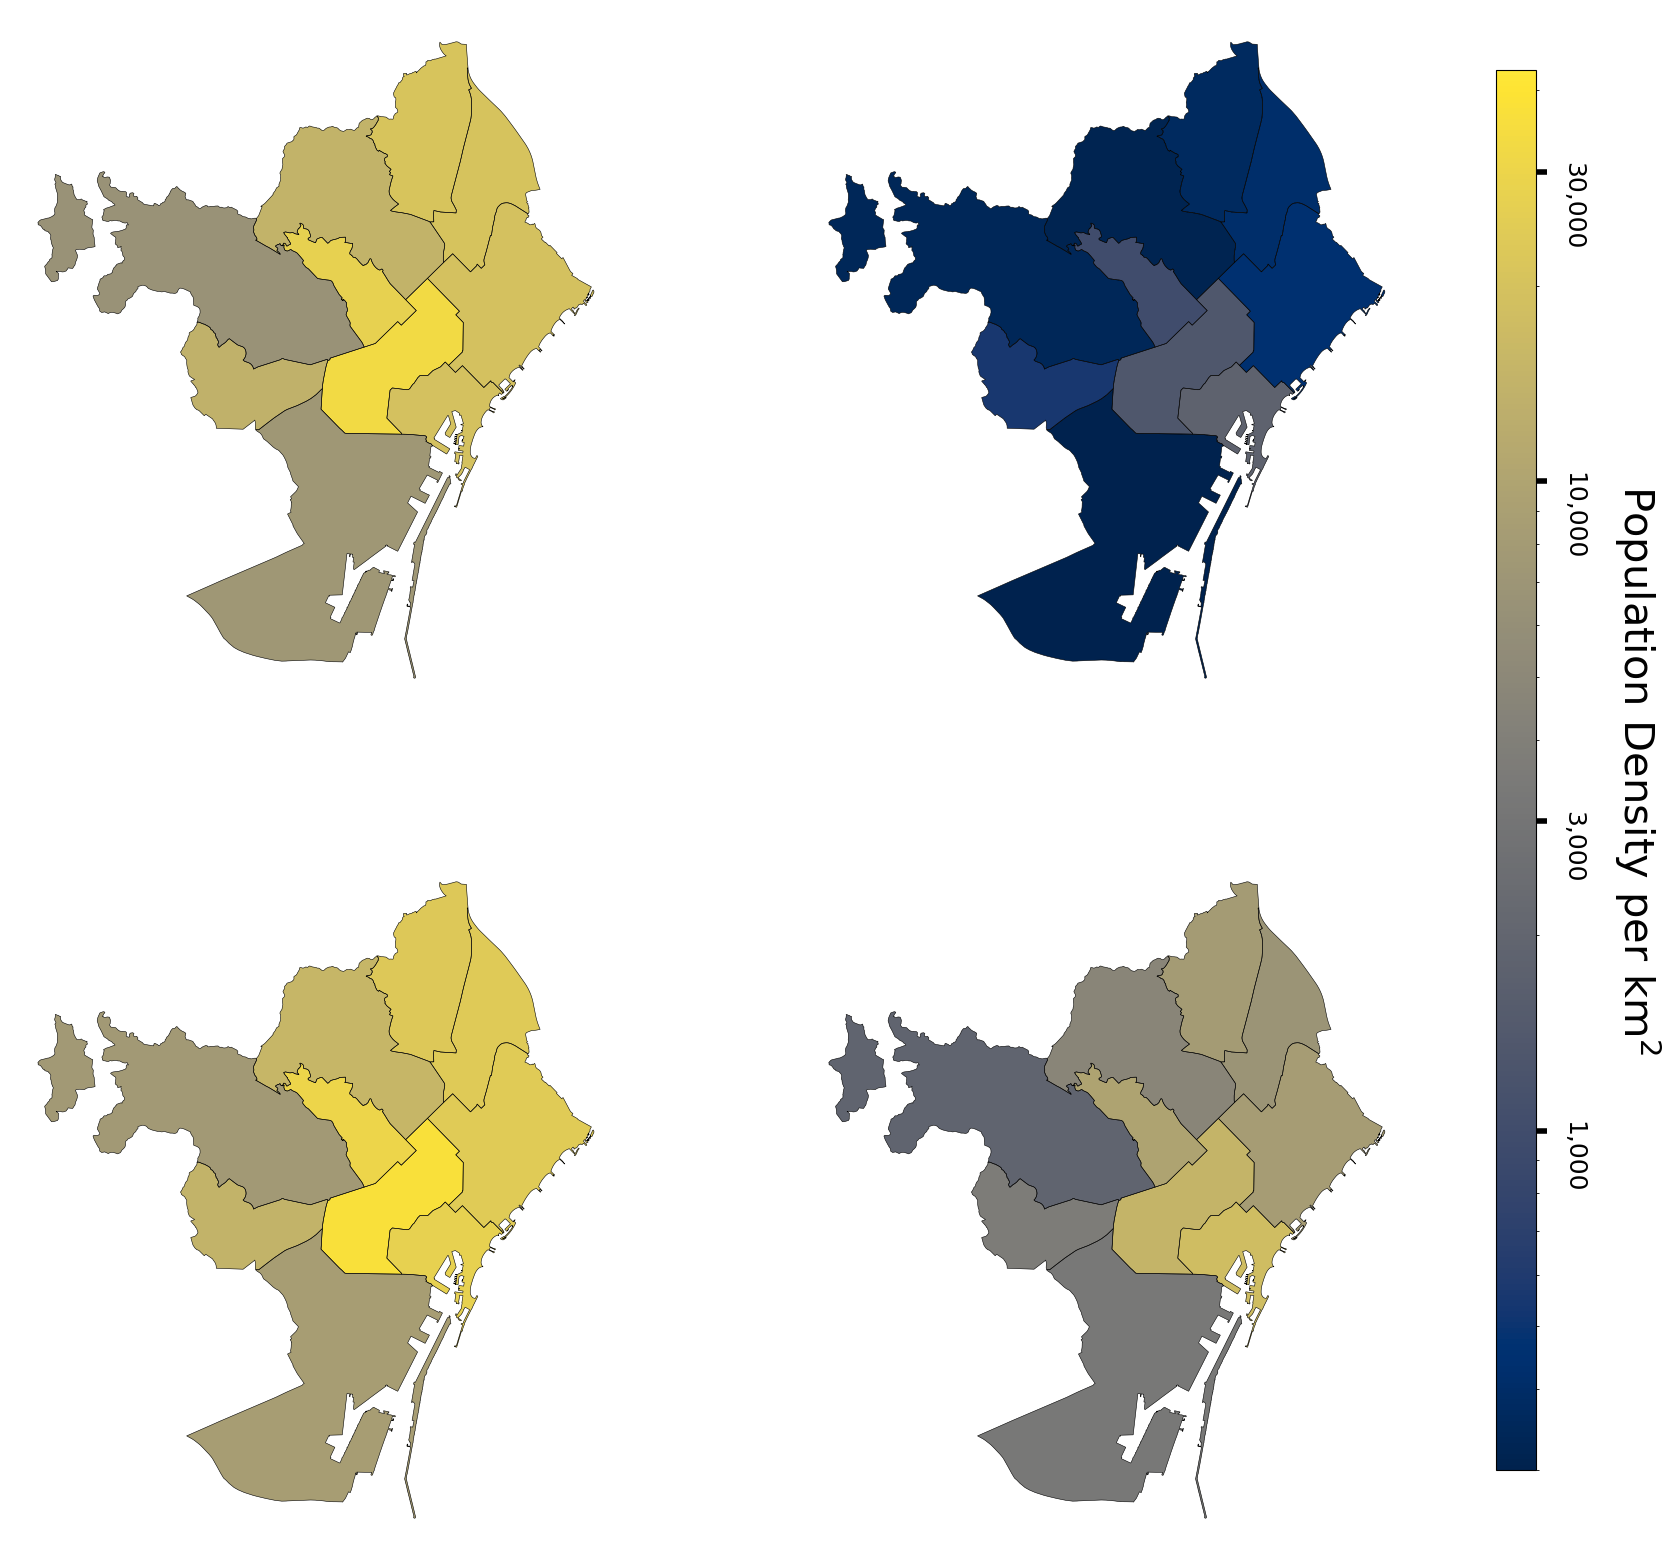

In [197]:
level = 'District'
vmin, vmax = 3000, 50000    # no se ve 1997 imm - todo azul
vmin, vmax = 600, 60000     # recupera algo de color, pero mucho azul
vmin, vmax = 300, 43000     # se ve bien, densidad total algo amarilla de más

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
plot_density(1997, level, axs[0,0])
plot_density(2025, level, axs[1,0])
plot_immigrant_density(1997, level, axs[0,1])
plot_immigrant_density(2025, level, axs[1,1])

add_legend(fig)

plt.show()
